In [2]:
import datetime
import warnings
warnings.filterwarnings('ignore')
import torch
from glob import glob
import os
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from tqdm import tqdm
import numpy as np
from torchvision import transforms
import torchvision.models as models
import torch.nn as nn
from torch.nn import functional as F
from sklearn.model_selection import KFold
import time
from efficientnet_pytorch import EfficientNet
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from torch_poly_lr_decay import PolynomialLRDecay
import random
from torchvision import models
from sklearn.metrics import accuracy_score, log_loss
import math
import librosa

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
torch.set_num_threads(8)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [19]:
dir_in = "./datasets/train/africa"
file_list = os.listdir(dir_in)
for file in file_list:
    if file.endswith(".wav"):
        print(file)
#africa_ex1 = glob('dataset/train/africa/*.wav')

common_voice_en_17272559.wav
common_voice_en_18833169.wav
common_voice_en_18945143.wav
common_voice_en_168685.wav
common_voice_en_214510.wav
common_voice_en_17272311.wav
common_voice_en_20531983.wav
common_voice_en_18518380.wav
common_voice_en_18341952.wav
common_voice_en_18835334.wav
common_voice_en_19773837.wav
common_voice_en_19490515.wav
common_voice_en_22179521.wav
common_voice_en_18715418.wav
common_voice_en_17271682.wav
common_voice_en_18910203.wav
common_voice_en_19754629.wav
common_voice_en_19783947.wav
common_voice_en_17343635.wav
common_voice_en_18248293.wav
common_voice_en_22940955.wav
common_voice_en_18835320.wav
common_voice_en_22938240.wav
common_voice_en_22940996.wav
common_voice_en_17272295.wav
common_voice_en_19999059.wav
common_voice_en_21342458.wav
common_voice_en_18908216.wav
common_voice_en_18835131.wav
common_voice_en_18835184.wav
common_voice_en_18834966.wav
common_voice_en_19984240.wav
common_voice_en_17272659.wav
common_voice_en_17256515.wav
common_voice_en_18

---

In [29]:
africa_ex1 = 'common_voice.wav'

In [3]:
import numpy as np
import librosa

def get_melspectrogram_db(file_path, sr=None, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300, top_db=80):
    wav,sr = librosa.load(file_path,sr=sr)
    if wav.shape[0]<5*sr:
        wav=np.pad(wav,int(np.ceil((5*sr-wav.shape[0])/2)),mode='reflect')
        
    else:
        wav=wav[:5*sr]
    spec=librosa.feature.melspectrogram(wav, sr=sr, n_fft=n_fft, hop_length=hop_length,n_mels=n_mels,fmin=fmin,fmax=fmax)
    spec_db=librosa.power_to_db(spec,top_db=top_db)
    
    return spec_db

In [52]:
get_melspectrogram_db(africa_ex1, sr=16000)

array([[-45.021706, -45.021706, -45.021706, ..., -28.46846 , -33.066696,
        -28.08957 ],
       [-45.021706, -45.021706, -45.021706, ..., -33.386353, -31.23667 ,
        -26.057806],
       [-45.021706, -45.021706, -45.021706, ..., -17.478779, -13.195372,
        -14.487791],
       ...,
       [-45.021706, -45.021706, -45.021706, ..., -45.021706, -45.021706,
        -45.021706],
       [-45.021706, -45.021706, -45.021706, ..., -45.021706, -45.021706,
        -45.021706],
       [-45.021706, -45.021706, -45.021706, ..., -45.021706, -45.021706,
        -45.021706]], dtype=float32)

In [30]:
data1, sr1 = librosa.load(africa_ex1, sr=16000)

In [55]:
data1.shape[0]

115584

In [58]:
data1[:5*16000].shape

(80000,)

In [63]:
africa_ex1 = 'common_voice.wav'
data1, sr1 = librosa.load(africa_ex1, sr=16000)
mel_africa_wav = librosa.feature.melspectrogram(data1, sr=16000, n_fft=2048, win_length=200, hop_length=160, n_mels=64)
mel_africa_wav

array([[0.00000000e+00, 0.00000000e+00, 1.09342108e-13, ...,
        3.92185996e-07, 1.39143395e-07, 3.39177888e-07],
       [0.00000000e+00, 0.00000000e+00, 1.09157238e-13, ...,
        9.95654887e-07, 1.94803462e-07, 8.49502499e-07],
       [0.00000000e+00, 0.00000000e+00, 1.08851005e-13, ...,
        1.34179049e-06, 1.75701445e-07, 1.12314069e-06],
       ...,
       [0.00000000e+00, 0.00000000e+00, 4.49644865e-14, ...,
        8.29698266e-09, 9.12768083e-09, 3.21373572e-09],
       [0.00000000e+00, 0.00000000e+00, 4.43796746e-14, ...,
        2.39989895e-09, 3.32916317e-09, 1.76992021e-09],
       [0.00000000e+00, 0.00000000e+00, 8.99734236e-15, ...,
        5.83970441e-11, 1.12407923e-10, 1.88435836e-10]], dtype=float32)

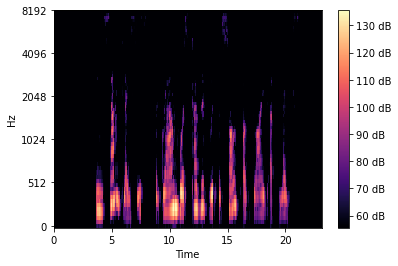

In [68]:
import librosa.display

librosa.display.specshow(librosa.amplitude_to_db(mel_africa_wav, ref=0.00002), sr=16000, y_axis='mel', x_axis='time')
plt.colorbar(format='%2.0f dB')
plt.show()

In [69]:
def pad_or_truncate(x, audio_length):
    """Pad all audio to specific length."""
    length = len(x)
    if length <= audio_length:
        return np.concatenate((x, np.zeros(audio_length - length)), axis=0), length
    else:
        return x[:audio_length], audio_length


----

### path 지정

In [4]:
africa_train = sorted(glob("./datasets/train/africa/*.wav"))
australia_train = sorted(glob("./datasets/train/australia/*.wav"))
canada_train = sorted(glob("./datasets/train/canada/*.wav"))
england_train = sorted(glob("./datasets/train/england/*.wav"))
hongkong_train = sorted(glob("./datasets/train/hongkong/*.wav"))
us_train = sorted(glob("./datasets/train/us/*.wav"))

sample_submission = pd.read_csv("./datasets/sample_submission.csv")
#test_paths = [f'./datasets/test/{k}']

In [6]:
test_path = glob("./datasets/test/*.wav")

In [5]:
def load_data(paths):
    result = []
    for path in tqdm(paths):
        data, sr = librosa.load(path, sr=16000)
        result.append(data)
    result = np.array(result)
    
    return result

In [35]:
# africa_train_data = load_data(africa_train)
# np.save("./datasets/aftrica-sorted.npy", africa_train_data)

# australia_train_data = load_data(australia_train)
# np.save("./datasets/australia-sorted.npy", australia_train_data)

# canada_train_data = load_data(canada_train)
# np.save("./datasets/canada-sorted.npy", canada_train_data)

# england_train_data = load_data(england_train)
# np.save("./datasets/england-sorted.npy", england_train_data)

# hongkong_train_data = load_data(hongkong_train)
# np.save("./datasets/hongkong-sorted.npy", hongkong_train_data)

# us_train_data = load_data(us_train)
# np.save("./datasets/us-sorted.npy", us_train_data)

100%|███████████████████████████████████████████████████████████████████████| 10000/10000 [18:50<00:00,  8.84it/s]


In [44]:
# test_data = load_data(test_path) #6100개
# np.save("./datasets/test_npy.npy", test_data)

100%|█████████████████████████████████████████████████████████████████████████| 6100/6100 [13:22<00:00,  7.60it/s]


In [4]:
africa_train_data = np.load("./datasets/africa-sorted.npy", allow_pickle = True)
australia_train_data = np.load("./datasets/australia-sorted.npy", allow_pickle = True)
canada_train_data = np.load("./datasets/canada-sorted.npy", allow_pickle = True)
england_train_data = np.load("./datasets/england-sorted.npy", allow_pickle = True)
hongkong_train_data = np.load("./datasets/hongkong-sorted.npy", allow_pickle = True)
us_train_data = np.load("./datasets/us-sorted.npy", allow_pickle = True)
train_data_list = [africa_train_data, australia_train_data, canada_train_data, england_train_data, hongkong_train_data, us_train_data]

In [5]:
train_x = np.concatenate(train_data_list ,axis=0)
train_x.shape

(25520,)

-----

feature 자르기

`wav
  sr: 32000 
  window_size: 1024
  hop_length: 320
  mel_bins: 64
  `

In [6]:
def get_feature(data, sr=16000, n_fft=2048, win_length=200, hop_length=160, n_mels=64):
    
    mel = []
    for i in tqdm(data):
        mel_ = librosa.feature.melspectrogram(i, sr=sr, n_fft=n_fft, win_length = win_length, hop_length = hop_length, n_mels = n_mels)
        mel.append(mel_)
    #mel = np.array(mel)
    mel = np.array(mel, dtype=np.float32)
    mel = librosa.power_to_db(mel, ref=np.max)
    #정규화를 여기서 해줘도 되고 , 뒤에서 데이터 다 만든후에 해줘도됨.
    
#     mel_mean = mel.mean()
#     mel = (mel - mel_mean)

    
    return mel


In [7]:
def set_length(data, d_mini):
    result = []
    for value in tqdm(data):
        value = value[:d_mini]
        if len(value) < d_mini:
            value = np.append(value, [0]*(d_mini-len(value))) #kinda padding
        result.append(value)
    result = np.array(result)
    
    return result

In [7]:
train_x

array([array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
               1.3940811e-06, -1.0920638e-06,  1.0484886e-06], dtype=float32),
       array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
              -1.4028327e-05, -1.0613157e-05, -1.7424460e-05], dtype=float32),
       array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), ...,
       array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
       array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
              -2.5764151e-05,  1.5654117e-05,  2.3484859e-05], dtype=float32),
       array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
               7.1461989e-05, -3.5540674e-05,  1.9304553e-05], dtype=float32)],
      dtype=object)

`win_length` : 음성을 작은 조각으로 자를때 작은 조각의 크기.   
`hop_length` : 음성을 작은 조각으로 자를때 자르는 간격  

In [8]:
train_x = set_length(train_x, 100000)

100%|█████████████████████████████████████████████████████████████████████| 25520/25520 [00:13<00:00, 1830.12it/s]


In [9]:
train_x.shape

(25520, 100000)

In [1]:
get_feature

NameError: name 'get_feature' is not defined

In [ ]:
#train_x = np.concatenate(train_data_list ,axis=0)
train_x_200 = get_feature(data = train_x, win_length=200)
train_x_400 = get_feature(data = train_x, win_length=400)
train_x_800 = get_feature(data = train_x, win_length=800)
train_x_1000 = get_feature(data = train_x, win_length=1000)

train_x_200 = train_x_200.reshape(train_x_200.shape[0], train_x_200.shape[1], train_x_200.shape[2], 1)
train_x_400 = train_x_400.reshape(train_x_400.shape[0], train_x_400.shape[1], train_x_400.shape[2], 1)
train_x_800 = train_x_800.reshape(train_x_800.shape[0], train_x_800.shape[1], train_x_800.shape[2], 1)
train_x_1000 = train_x_1000.reshape(train_x_1000.shape[0], train_x_1000.shape[1], train_x_1000.shape[2], 1)


100%|███████████████████████████████████████████████████████████████████████| 25520/25520 [04:48<00:00, 88.56it/s]


메모리 부족해서 계속 커널 쥬금ㅠ  
getfeature함수에서  `np.array(data, dtype = np.float32)`  데이터타입 바꿔줘야 할듯 ㅠ

In [ ]:
train_reshape_list = [train_x_200, train_x_400, train_x_800, train_x_1000]
train_x_multi = np.concatenate(train_reshape_list, -1)
np.save('./datasets/train_x_multi.npy', train_x_multi)

In [ ]:
test_x = np.load('./datasets/test_npy.npy', allow_pickle=True)

test_x = set_length(test_x, 100000)
test_x_200 = get_feature(data = test_x, win_length=200)
test_x_400 = get_feature(data = test_x, win_length=400)
test_x_800 = get_feature(data = test_x, win_length=800)
test_x_1000 = get_feature(data = test_x, win_length=1000)


test_x_200 = test_x_200.reshape(test_x_200.shape[0], test_x_200.shape[1], test_x_200.shape[2], 1)
test_x_400 = test_x_400.reshape(test_x_400.shape[0], test_x_400.shape[1], test_x_400.shape[2], 1)
test_x_800 = test_x_800.reshape(test_x_800.shape[0], test_x_800.shape[1], test_x_800.shape[2], 1)
test_x_1000 = test_x_1000.reshape(test_x_1000.shape[0], test_x_1000.shape[1], test_x_1000.shape[2], 1)

test_x_reshape = [test_x_200, test_x_400, test_x_800, test_x_1000]
test_x_multi = np.concatenate(test_x_reshape, -1)
np.save('./datasets/test_x_multi.npy', test_x_multi)

----